In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

from rapidgbm import RapidGBMTuner

import mplhep as hep
hep.style.use([hep.style.ATLAS])
import pickle


In [64]:
def concatenate_parquet_files(path):
    """
    Concatenate all parquet files in the given directory into a single DataFrame.

    Parameters:
    path (str): The directory containing the parquet files.

    Returns:
    pd.DataFrame: The concatenated DataFrame.
    """
    # List all files in the directory
    files = [f for f in os.listdir(path) if f.endswith('.parquet')]
    
    # Read and concatenate all parquet files
    dataframes = [pd.read_parquet(os.path.join(path, file)) for file in files]
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    return concatenated_df

In [65]:
path_zee = '/groups/hep/kinch/data/preprocessed_data/files_for_dual_models/zee_deriv/pairs'
path_ttbar = '/groups/hep/kinch/data/preprocessed_data/files_for_dual_models/ttbar/pairs'

data_ttbar = concatenate_parquet_files(path_ttbar)
data_zeederiv = concatenate_parquet_files(path_zee)

In [66]:
def ATLAS_labels(dataframe):
        ATLAS_Energy = (dataframe['el1_pt'] > 10000) & (dataframe['el2_pt'] > 10000)
        ATLAS_Eta = (np.abs(dataframe['el1_eta']) < 2.47) & (np.abs(dataframe['el2_eta']) < 2.47)
        ATLAS_Crack = (np.abs(dataframe['el1_eta']) > 1.37) & (np.abs(dataframe['el1_eta']) < 1.52) | (np.abs(dataframe['el2_eta']) > 1.37) & (np.abs(dataframe['el2_eta']) < 1.52)

        ATLAS_d0sigd0 = ( (np.abs(dataframe['el1_GSFTrack_d0'])/np.sqrt(dataframe['el1_GSF_Track_Var1']) ) < 5) & \
                ( (np.abs(dataframe['el2_GSFTrack_d0'])/np.sqrt(dataframe['el2_GSF_Track_Var1']) ) < 5)

        dz = np.abs(dataframe['el1_GSFTrack_z0'] - dataframe['el2_GSFTrack_z0'])

        dz_sintheta1 = (dz * dataframe['el1_GSFTrack_theta']) < 0.5 * np.sqrt(2)
        dz_sintheta2 = (dz * dataframe['el2_GSFTrack_theta']) < 0.5 * np.sqrt(2)

        ATLAS_charge = dataframe['el1_charge'] != dataframe['el2_charge']

        ATLAS_dz = dz_sintheta1 & dz_sintheta2

        ATLAS_label = ATLAS_Eta & ~ATLAS_Crack & ATLAS_d0sigd0 & ATLAS_dz &\
        dataframe['el1_DFCommonElectrons_LHLoose'] & dataframe['el2_DFCommonElectrons_LHLoose'] &\
        ATLAS_charge & ATLAS_Energy

        dataframe['dz'] = dz

        dataframe['ATLAS_label'] = ATLAS_label
        dataframe['ATLAS_Energy'] = ATLAS_Energy
        dataframe['ATLAS_Eta'] = ATLAS_Eta
        dataframe['ATLAS_Crack'] = ~ATLAS_Crack
        dataframe['ATLAS_d0sigd0'] = ATLAS_d0sigd0
        dataframe['ATLAS_dzsintheta'] = ATLAS_dz
        dataframe['ATLAS_charge'] = ATLAS_charge
        return dataframe

In [67]:
# data_higgs.rename(columns={'el2_DFcommonElectrons_LHLoose': 'el2_DFCommonElectrons_LHLoose'}, inplace=True)
# data_higgs.rename(columns={'el1_DFcommonElectrons_LHLoose': 'el1_DFCommonElectrons_LHLoose'}, inplace=True)

In [68]:
data_zeederiv = ATLAS_labels(data_zeederiv)
data_ttbar = ATLAS_labels(data_ttbar)

In [69]:
print(*data_zeederiv.columns)

event_index el1_index el2_index runNumber eventNumber eventTrigger actualInteractionsPerCrossing averageInteractionsPerCrossing m_ee isZ el1_pt el1_eta el1_phi el1_m el1_charge el1_f1 el1_neflowisol20 el1_truthPdgId el1_truthType el1_truthOrigin el1_DFCommonElectronsECIDS el1_DFCommonElectronsECIDSResult el1_DFCommonElectrons_LHLoose el1_DFCommonElectronsLHLooseIsEMValue el1_DFCommonElectronsLHVeryLoose el1_DFCommonElectronsLHVeryLooseIsEMValue el1_DFCommonElectronsDNN_pel el1_DFCommonElectronsDNN_pcf el1_DFCommonElectronsDNN_ppc el1_DFCommonElectronsDNN_phf el1_DFCommonElectronsDNN_ple el1_DFCommonElectronsDNN_plh el1_GSFTrack_d0 el1_GSFTrack_z0 el1_GSFTrack_theta el1_GSFTrack_phi el1_GSFTrack_qOverP el1_GSF_dR el1_GSF_Track_Var0 el1_GSF_Track_Var1 el1_GSF_Track_Var2 el1_GSF_Track_Var3 el1_GSF_Track_Var4 el1_ptvarcone20 el1_topoetcone20 el1_topoetcone40 el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000 el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000 el1_core57cellsE

In [70]:
# data_higgs.drop(columns=['isZnew', 'el_index'], inplace=True)
# data_zeederiv.drop(columns=['el1_index', 'el2_index'], inplace=True)
# data_ttbar.drop(columns=['el1_index', 'el2_index'], inplace=True)

In [71]:
def compare_dataframe_columns(df1, df2):
    """
    Compare the columns of two DataFrames and print the differences.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame.
    df2 (pd.DataFrame): The second DataFrame.
    """
    columns_df1 = set(df1.columns)
    columns_df2 = set(df2.columns)

    # Columns in df1 but not in df2
    diff1 = columns_df1 - columns_df2
    if diff1:
        print("Columns in df1 but not in df2:")
        for col in diff1:
            print(col)
    else:
        print("No columns in df1 that are not in df2.")

    # Columns in df2 but not in df1
    diff2 = columns_df2 - columns_df1
    if diff2:
        print("Columns in df2 but not in df1:")
        for col in diff2:
            print(col)
    else:
        print("No columns in df2 that are not in df1.")


In [72]:
compare_dataframe_columns(data_zeederiv, data_ttbar)

No columns in df1 that are not in df2.
No columns in df2 that are not in df1.


In [73]:
event_trigger_ndarray = np.vstack(data_ttbar['eventTrigger'].values)
# print(event_trigger_ndarray.shape)
# unique_combinations = np.unique(event_trigger_ndarray, axis=0)
# print(unique_combinations)
# print(f"Number of unique combinations: {unique_combinations.shape[0]}")

# Calculate and print the frequency of each unique combination for the ttbar dataset
unique, counts = np.unique(event_trigger_ndarray, axis=0, return_counts=True)
frequency = dict(zip(map(tuple, unique), counts))
print("Frequency of each unique combination in ttbar dataset:")
for combination, count in frequency.items():
    print(f"{combination}: {count}")

# # same as above but for the zee_deriv dataset
event_trigger_ndarray = np.vstack(data_zeederiv['eventTrigger'].values)
# print(event_trigger_ndarray.shape)
# unique_combinations = np.unique(event_trigger_ndarray, axis=0)
# print(unique_combinations)
# print(f"Number of unique combinations: {unique_combinations.shape[0]}")

# Calculate and print the frequency of each unique combination for the zee_deriv dataset
unique, counts = np.unique(event_trigger_ndarray, axis=0, return_counts=True)
frequency = dict(zip(map(tuple, unique), counts))
print("Frequency of each unique combination in zee_deriv dataset:")
for combination, count in frequency.items():
    print(f"{combination}: {count}")
# same as above but for the zee_deriv dataset
# event_trigger_ndarray = np.vstack(data_zeederiv['eventTrigger'].values)
# print(event_trigger_ndarray.shape)
# unique_combinations = np.unique(event_trigger_ndarray, axis=0)
# print(unique_combinations)
# print(f"Number of unique combinations: {unique_combinations.shape[0]}")


Frequency of each unique combination in ttbar dataset:
(1, 1, 1, 0, 0, 1, 1, 1): 4821743
(1, 1, 1, 0, 1, 1, 1, 1): 377653
(1, 1, 1, 1, 1, 1, 1, 1): 39048
Frequency of each unique combination in zee_deriv dataset:
(1, 1, 1, 0, 0, 1, 1, 1): 1116623
(1, 1, 1, 0, 1, 1, 1, 1): 25917
(1, 1, 1, 1, 1, 1, 1, 1): 2236


Text(1, 0, '$m_{ee}$ [GeV]')

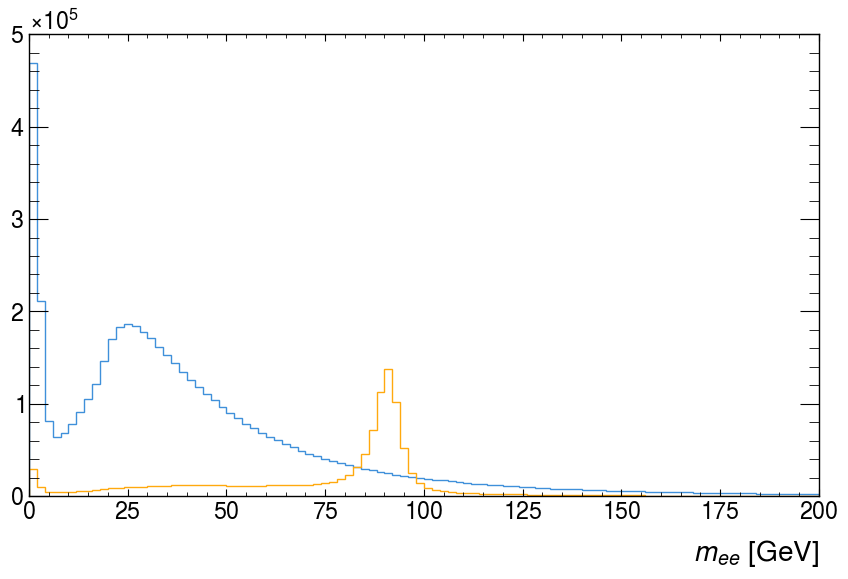

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(data_ttbar['m_ee'], bins=100, range=(0, 200), histtype='step', label='ttbar')
ax.hist(data_zeederiv['m_ee'], bins=100, range=(0, 200), histtype='step', label='zee_deriv')
ax.set_xlabel(r'$m_{ee}$ [GeV]')

In [75]:
event_trigger_ndarray = np.vstack(data_ttbar['eventTrigger'].values).sum(axis=1)
data_ttbar['trigger'] = (event_trigger_ndarray > 0)

event_trigger_ndarray = np.vstack(data_zeederiv['eventTrigger'].values).sum(axis=1)
data_zeederiv['trigger'] = (event_trigger_ndarray > 0)

In [76]:
print(data_zeederiv['isZ'].value_counts())
print(data_ttbar['isZ'].value_counts())

isZ
1    627233
0    517543
Name: count, dtype: int64
isZ
0    5238444
Name: count, dtype: int64


In [77]:
with open('iso_score_bdt_MC_zeederiv_ttbar_balanced_100ep_26Sept.pkl', 'rb') as file:
    iso_tuner = pickle.load(file)

In [78]:
iso_param_list1 = ['el1_ptvarcone20', 'el1_topoetcone20', 'el1_topoetcone40', 'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
               'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000', 'el1_core57cellsEnergyCorrection',
               'el1_topoetcone20ptCorrection', 'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
               'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500']
iso_param_list2 = ['el2_ptvarcone20', 'el2_topoetcone20', 'el2_topoetcone40', 'el2_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
               'el2_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000', 'el2_core57cellsEnergyCorrection',
               'el2_topoetcone20ptCorrection', 'el2_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
               'el2_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500']

In [79]:
with open('E_model_BDT_ttbar_Zeederiv_1Oct.pkl', 'rb') as file: #bdt_MC_HZg_mumu_1s02bkg_100ep_23Sept
    e_tuner = pickle.load(file)

In [80]:
e_param_list1 = ['el1_eta', 'el1_phi', 'el1_m', 'el1_charge', 'el1_f1',
       'el1_neflowisol20', 'el1_truthPdgId', 'el1_truthType',
       'el1_truthOrigin', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_LHLoose',
       'el1_DFCommonElectronsLHLooseIsEMValue',
       'el1_DFCommonElectronsLHVeryLoose',
       'el1_DFCommonElectronsLHVeryLooseIsEMValue',
       'el1_DFCommonElectronsDNN_pel', 'el1_DFCommonElectronsDNN_pcf',
       'el1_DFCommonElectronsDNN_ppc', 'el1_DFCommonElectronsDNN_phf',
       'el1_DFCommonElectronsDNN_ple', 'el1_DFCommonElectronsDNN_plh',
       'el1_GSFTrack_d0', 'el1_GSFTrack_z0', 'el1_GSFTrack_theta',
       'el1_GSFTrack_phi', 'el1_GSFTrack_qOverP', 'el1_GSF_dR',
       'el1_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el1_GSF_Track_Var2',
       'el1_GSF_Track_Var3', 'el1_GSF_Track_Var4', 'el1_ptvarcone20',
       'el1_topoetcone20', 'el1_topoetcone40',
       'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el1_core57cellsEnergyCorrection', 'el1_topoetcone20ptCorrection',
       'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
       'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500','el1_InDetTrack_d0', 'el1_InDetTrack_z0',
       'el1_InDetTrack_theta', 'el1_InDetTrack_phi', 'el1_InDetTrack_covdiag0',
       'el1_InDetTrack_covdiag1', 'el1_InDetTrack_covdiag2',
       'el1_InDetTrack_covdiag3', 'el1_InDetTrack_covdiag4', 'el1_InDet_dR' ]
e_param_list2 = ['el2_eta', 'el2_phi', 'el2_m', 'el2_charge', 'el2_f1',
       'el2_neflowisol20', 'el2_truthPdgId', 'el2_truthType',
       'el2_truthOrigin', 'el2_DFCommonElectronsECIDS',
       'el2_DFCommonElectronsECIDSResult', 'el2_DFCommonElectrons_LHLoose',
       'el2_DFCommonElectronsLHLooseIsEMValue',
       'el2_DFCommonElectronsLHVeryLoose',
       'el2_DFCommonElectronsLHVeryLooseIsEMValue',
       'el2_DFCommonElectronsDNN_pel', 'el2_DFCommonElectronsDNN_pcf',
       'el2_DFCommonElectronsDNN_ppc', 'el2_DFCommonElectronsDNN_phf',
       'el2_DFCommonElectronsDNN_ple', 'el2_DFCommonElectronsDNN_plh',
       'el2_GSFTrack_d0', 'el2_GSFTrack_z0', 'el2_GSFTrack_theta',
       'el2_GSFTrack_phi', 'el2_GSFTrack_qOverP', 'el2_GSF_dR',
       'el2_GSF_Track_Var0', 'el2_GSF_Track_Var1', 'el2_GSF_Track_Var2',
       'el2_GSF_Track_Var3', 'el2_GSF_Track_Var4', 'el2_ptvarcone20',
       'el2_topoetcone20', 'el2_topoetcone40',
       'el2_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el2_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el2_core57cellsEnergyCorrection', 'el2_topoetcone20ptCorrection',
       'el2_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
       'el2_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500','el2_InDetTrack_d0', 'el2_InDetTrack_z0',
       'el2_InDetTrack_theta', 'el2_InDetTrack_phi', 'el2_InDetTrack_covdiag0',
       'el2_InDetTrack_covdiag1', 'el2_InDetTrack_covdiag2',
       'el2_InDetTrack_covdiag3', 'el2_InDetTrack_covdiag4', 'el2_InDet_dR' ]

In [81]:
pred_iso1_ttbar = np.zeros(data_ttbar.shape[0])
pred_iso2_ttbar = np.zeros(data_ttbar.shape[0])
pred_iso1_zeederiv = np.zeros(data_zeederiv.shape[0])
pred_iso2_zeederiv = np.zeros(data_zeederiv.shape[0])

for i in range(5):
    with open(f'iso_score_bdt_MC_zeederiv_ttbar_cross{i}_100ep_26Sept.pkl', 'rb') as file: #bdt_MC_HZg_mumu_1s02bkg_100ep_23Sept
        tuneri = pickle.load(file)
    
    pred_iso1_ttbar[data_ttbar['eventNumber'] % 5 == i] = tuneri.predict_proba(data_ttbar[data_ttbar['eventNumber'] % 5 == i][iso_param_list1])
    pred_iso2_ttbar[data_ttbar['eventNumber'] % 5 == i] = tuneri.predict_proba(data_ttbar[data_ttbar['eventNumber'] % 5 == i][iso_param_list2])
    pred_iso1_zeederiv[data_zeederiv['eventNumber'] % 5 == i] = tuneri.predict_proba(data_zeederiv[data_zeederiv['eventNumber'] % 5 == i][iso_param_list1])
    pred_iso2_zeederiv[data_zeederiv['eventNumber'] % 5 == i] = tuneri.predict_proba(data_zeederiv[data_zeederiv['eventNumber'] % 5 == i][iso_param_list2])

data_ttbar['el1_isoScore'] = pred_iso1_ttbar
data_ttbar['el2_isoScore'] = pred_iso2_ttbar
data_zeederiv['el1_isoScore'] = pred_iso1_zeederiv
data_zeederiv['el2_isoScore'] = pred_iso2_zeederiv


In [82]:
# pred_iso1_ttbar = iso_tuner.predict_proba(data_ttbar[iso_param_list1])
# pred_iso2_ttbar = iso_tuner.predict_proba(data_ttbar[iso_param_list2])
# pred_iso1_zeederiv = iso_tuner.predict_proba(data_zeederiv[iso_param_list1])
# pred_iso2_zeederiv = iso_tuner.predict_proba(data_zeederiv[iso_param_list2])





# data_ttbar['el1_isoScore'] = pred_iso1_ttbar
# data_ttbar['el2_isoScore'] = pred_iso2_ttbar
# data_zeederiv['el1_isoScore'] = pred_iso1_zeederiv
# data_zeederiv['el2_isoScore'] = pred_iso2_zeederiv

In [83]:
pred_e1_ttbar = e_tuner.predict(data_ttbar[e_param_list1])
pred_e2_ttbar = e_tuner.predict(data_ttbar[e_param_list2])
pred_e1_zeederiv = e_tuner.predict(data_zeederiv[e_param_list1])
pred_e2_zeederiv = e_tuner.predict(data_zeederiv[e_param_list2])

In [84]:
print(pred_e1_ttbar.shape)
print(data_ttbar['el1_truth_px'].shape)
print(data_ttbar['eventNumber'].shape)

print(len(data_ttbar[e_param_list1]))

(5238444,)
(5238444,)
(5238444,)
5238444


In [85]:

#mass = np.sqrt(2 * row['el_pt'][i] * row['el_pt'][j] *(np.cosh(row['el_eta'][i] - row['el_eta'][j]) - np.cos(row['el_phi'][i] - row['el_phi'][j]))) / 1000

# p1_ttbar = pred_e1_ttbar * np.sin( 2*np.arctan(np.exp(-data_ttbar['el1_eta'])) )
# p2_ttbar = pred_e2_ttbar * np.sin( 2*np.arctan(np.exp(-data_ttbar['el2_eta'])) )
# p1_zeederiv = pred_e1_zeederiv * np.sin( 2*np.arctan(np.exp(-data_zeederiv['el1_eta'])) )
# p2_zeederiv = pred_e2_zeederiv * np.sin( 2*np.arctan(np.exp(-data_zeederiv['el2_eta'])) )


# m_ee_ttbar = np.sqrt( 2 * p1_ttbar * p2_ttbar * (np.cosh(data_ttbar['el1_eta'] - data_ttbar['el2_eta']) - np.cos(data_ttbar['el1_phi'] - data_ttbar['el2_phi'])) ) / 1000
# m_ee_zeederiv = np.sqrt( 2 * p1_zeederiv * p2_zeederiv * (np.cosh(data_zeederiv['el1_eta'] - data_zeederiv['el2_eta']) - np.cos(data_zeederiv['el1_phi'] - data_zeederiv['el2_phi'])) ) / 1000

pt1_bdt_ttbar = pred_e1_ttbar / np.cosh(data_ttbar['el1_eta'])
pt2_bdt_ttbar = pred_e2_ttbar / np.cosh(data_ttbar['el2_eta'])

pt1_bdt_zeederiv = pred_e1_zeederiv / np.cosh(data_zeederiv['el1_eta'])
pt2_bdt_zeederiv = pred_e2_zeederiv / np.cosh(data_zeederiv['el2_eta'])

m_ee_ttbar = np.sqrt( 2 * pt1_bdt_ttbar * pt2_bdt_ttbar * (np.cosh(data_ttbar['el1_eta'] - data_ttbar['el2_eta']) - np.cos(data_ttbar['el1_phi'] - data_ttbar['el2_phi'])) ) / 1000
m_ee_zeederiv = np.sqrt( 2 * pt1_bdt_zeederiv * pt2_bdt_zeederiv * (np.cosh(data_zeederiv['el1_eta'] - data_zeederiv['el2_eta']) - np.cos(data_zeederiv['el1_phi'] - data_zeederiv['el2_phi'])) ) / 1000

data_ttbar['m_ee_bdt'] = m_ee_ttbar
data_zeederiv['m_ee_bdt'] = m_ee_zeederiv


m_ee_ttbar = np.sqrt( (data_ttbar['el1_truth_E'] + data_ttbar['el2_truth_E'])**2 - (data_ttbar['el1_truth_px']+data_ttbar['el2_truth_px'])**2 - (data_ttbar['el1_truth_py']+data_ttbar['el2_truth_py'])**2 - (data_ttbar['el1_truth_pz']+data_ttbar['el2_truth_pz'])**2 ) / 1000
m_ee_zeederiv = np.sqrt( (data_zeederiv['el1_truth_E'] + data_zeederiv['el2_truth_E'])**2 - (data_zeederiv['el1_truth_px']+data_zeederiv['el2_truth_px'])**2 - (data_zeederiv['el1_truth_py']+data_zeederiv['el2_truth_py'])**2 - (data_zeederiv['el1_truth_pz']+data_zeederiv['el2_truth_pz'])**2 ) / 1000


data_ttbar['m_ee_truth'] = m_ee_ttbar
data_zeederiv['m_ee_truth'] = m_ee_zeederiv

no
670821.4375
502339.9375
no


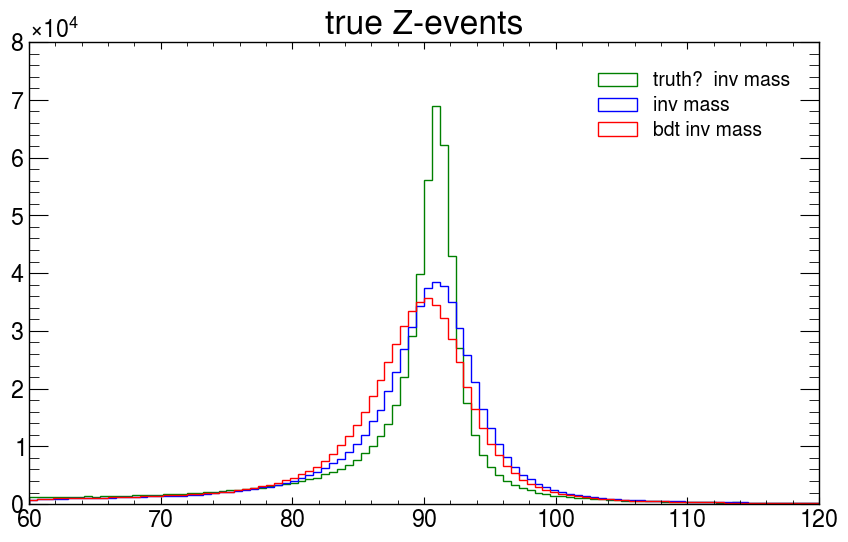

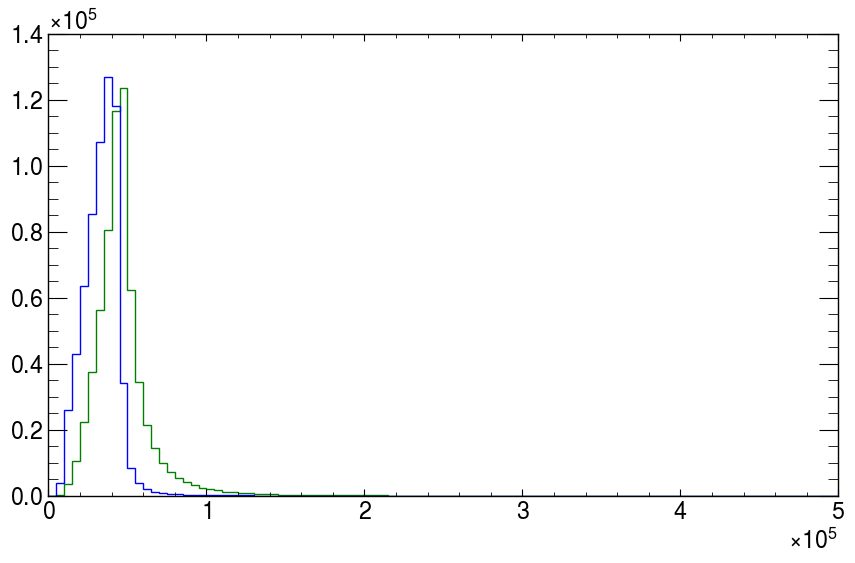

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(data_zeederiv[data_zeederiv['isZ'] == 1]['m_ee_truth'], bins=100, range=(60, 120), color='green', histtype='step', label='truth inv mass')
ax.hist(data_zeederiv[data_zeederiv['isZ'] == 1]['m_ee'], bins=100, range=(60, 120),color='blue', histtype='step', label='ATLAS inv mass')
ax.hist(data_zeederiv[data_zeederiv['isZ'] == 1]['m_ee_bdt'], bins=100, range=(60, 120),color = 'red', histtype='step', label='bdt inv mass')
print('no')
ax.set_title('true Z-events')
# ax.set_yscale('log')
ax.legend()
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(data_zeederiv[data_zeederiv['isZ'] == 1]['el1_pt'], bins=100, range=(0, 500000), color='green', histtype='step', label='truth?  inv mass')
ax.hist(data_zeederiv[data_zeederiv['isZ'] == 1]['el2_pt'], bins=100, range=(0, 500000),color='blue', histtype='step', label='inv mass')
print(np.max(data_zeederiv[data_zeederiv['isZ'] == 1]['el1_pt']))
print(np.max(data_zeederiv[data_zeederiv['isZ'] == 1]['el2_pt']))
print('no')

In [26]:
# do we even like isolated electrons? (type 2)
print(data_zeederiv[data_zeederiv['isZ'] == 1]['el1_truthType'].value_counts())
print(data_zeederiv[data_zeederiv['isZ'] == 1]['el2_truthType'].value_counts())
# it seems that we really really do!
print(data_zeederiv[data_zeederiv['isZ'] == 0]['el1_truthType'].value_counts())
print(data_zeederiv[data_zeederiv['isZ'] == 0]['el2_truthType'].value_counts())

el1_truthType
2    627233
Name: count, dtype: int64
el2_truthType
2    627233
Name: count, dtype: int64
el1_truthType
2     378775
17     59454
4      47355
0      22657
16      5475
15      3019
3        689
7         79
8         24
14        14
6          1
13         1
Name: count, dtype: int64
el2_truthType
17    203883
0     132755
4      74859
2      65182
16     30095
15      7489
3       2764
7        299
8        144
14        54
13        15
6          4
Name: count, dtype: int64


no


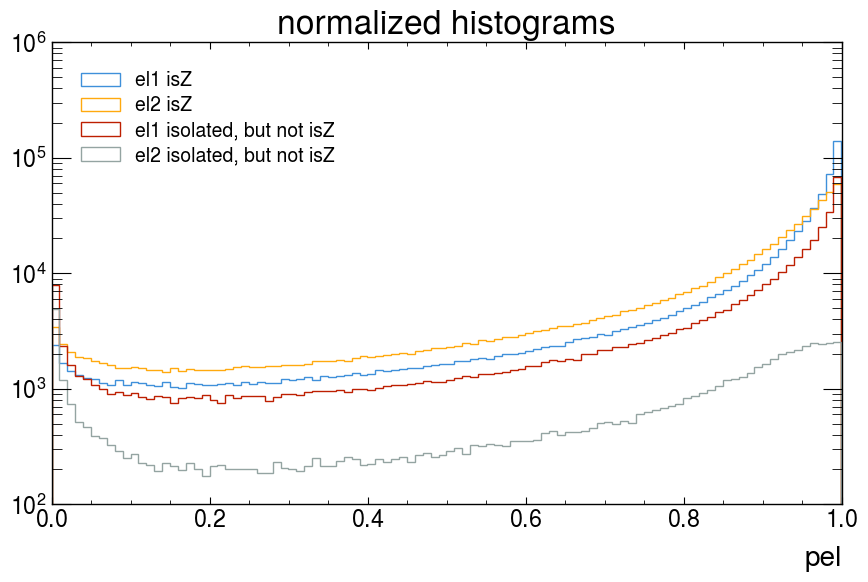

In [27]:
#wth is pel anyway?
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(data_zeederiv[data_zeederiv['isZ'] == 1]['el1_DFCommonElectronsDNN_pel'], bins=100, histtype='step', label='el1 isZ')
ax.hist(data_zeederiv[data_zeederiv['isZ'] == 1]['el2_DFCommonElectronsDNN_pel'], bins=100, histtype='step', label='el2 isZ')
ax.hist(data_zeederiv[(data_zeederiv['isZ'] == 0) * (data_zeederiv['el1_truthType'] == 2)]['el1_DFCommonElectronsDNN_pel'], bins=100, histtype='step', label='el1 isolated, but not isZ')
ax.hist(data_zeederiv[(data_zeederiv['isZ'] == 0) * (data_zeederiv['el2_truthType'] == 2)]['el2_DFCommonElectronsDNN_pel'], bins=100, histtype='step', label='el2 isolated, but not isZ')
print('no')
ax.set_title('normalized histograms')
ax.set_xlabel('pel')
ax.set_yscale('log')
ax.legend()

no


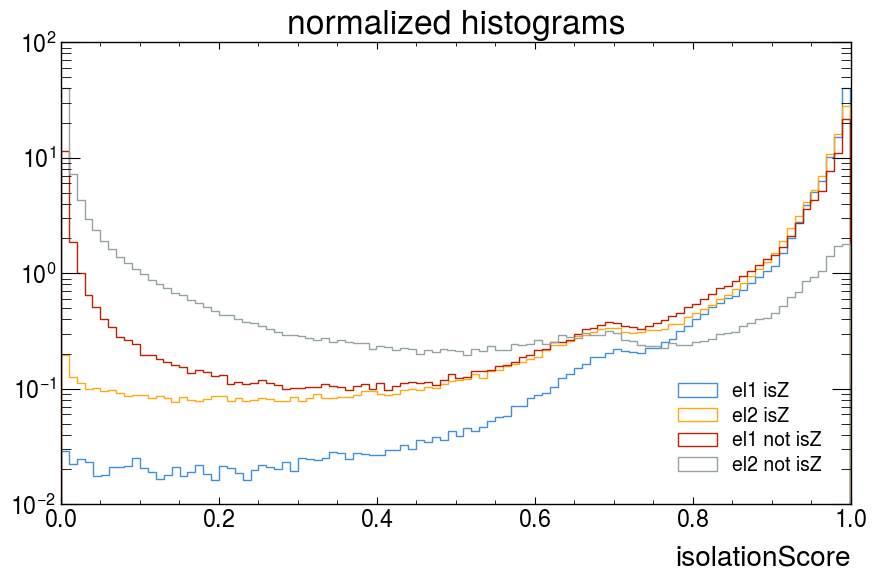

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(data_zeederiv[data_zeederiv['isZ'] == 1]['el1_isoScore'], bins=100, histtype='step', label='el1 isZ', density=True)
ax.hist(data_zeederiv[data_zeederiv['isZ'] == 1]['el2_isoScore'], bins=100, histtype='step', label='el2 isZ', density=True)
ax.hist(data_zeederiv[(data_zeederiv['isZ'] == 0)]['el1_isoScore'], bins=100, histtype='step', label='el1 not isZ', density=True)
ax.hist(data_zeederiv[(data_zeederiv['isZ'] == 0)]['el2_isoScore'], bins=100, histtype='step', label='el2 not isZ', density=True)
ax.set_xlabel('isolationScore')
ax.set_yscale('log')
ax.set_title('normalized histograms')
ax.legend()

print('no')

In [29]:
drop_list = ['isZ', 'm_ee', 'event_index', 'runNumber', 'eventNumber', 'el1_pt', 'el2_pt'
             ,'el1_m', 'el2_m', 'el1_truthPdgId', 'el2_truthPdgId', 'el1_truthOrigin', 'el2_truthOrigin', 'el1_truthType', 'el2_truthType',
             'el1_GSFTrack_qOverP', 'el2_GSFTrack_qOverP', 'el1_GSF_Track_Var0', 'el2_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el2_GSF_Track_Var1',
             'el1_GSF_Track_Var2', 'el2_GSF_Track_Var2', 'el1_GSF_Track_Var4', 'el2_GSF_Track_Var4',
             'el1_GSFTrack_theta', 'el2_GSFTrack_theta', 'el1_GSFTrack_phi', 'el2_GSFTrack_phi', 'el1_phi', 'el2_phi'
             , 'el1_DFCommonElectrons_LHLoose', 'el2_DFCommonElectrons_LHLoose',
             'el1_GSFTrack_z0', 'el2_GSFTrack_z0', 'el1_GSF_Track_Var3', 'el2_GSF_Track_Var3', 'el1_GSF_dR', 'el2_GSF_dR',
             'el1_GSFTrack_d0', 'el2_GSFTrack_d0', 'ATLAS_label', 'ATLAS_Energy', 'ATLAS_Eta', 'ATLAS_Crack',
       'ATLAS_d0sigd0', 'ATLAS_dzsintheta', 'ATLAS_charge', 'el1_f1', 'el2_f1','eventTrigger','trigger']

In [30]:
print(len(data_ttbar['isZ'][data_ttbar['isZ'] == 1]))

0


In [31]:
print(*data_ttbar.columns)

event_index el1_index el2_index runNumber eventNumber eventTrigger actualInteractionsPerCrossing averageInteractionsPerCrossing m_ee isZ el1_pt el1_eta el1_phi el1_m el1_charge el1_f1 el1_neflowisol20 el1_truthPdgId el1_truthType el1_truthOrigin el1_DFCommonElectronsECIDS el1_DFCommonElectronsECIDSResult el1_DFCommonElectrons_LHLoose el1_DFCommonElectronsLHLooseIsEMValue el1_DFCommonElectronsLHVeryLoose el1_DFCommonElectronsLHVeryLooseIsEMValue el1_DFCommonElectronsDNN_pel el1_DFCommonElectronsDNN_pcf el1_DFCommonElectronsDNN_ppc el1_DFCommonElectronsDNN_phf el1_DFCommonElectronsDNN_ple el1_DFCommonElectronsDNN_plh el1_GSFTrack_d0 el1_GSFTrack_z0 el1_GSFTrack_theta el1_GSFTrack_phi el1_GSFTrack_qOverP el1_GSF_dR el1_GSF_Track_Var0 el1_GSF_Track_Var1 el1_GSF_Track_Var2 el1_GSF_Track_Var3 el1_GSF_Track_Var4 el1_ptvarcone20 el1_topoetcone20 el1_topoetcone40 el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000 el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000 el1_core57cellsE

In [32]:
pred_z_param_list = ['el1_isoScore', 'el2_isoScore', 'dz', 'el1_GSF_Track_Var0', 'el2_GSF_Track_Var0', 
                     'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing',
                     'el1_DFCommonElectronsDNN_pel', 'el2_DFCommonElectronsDNN_pel']
                    #  'el1_DFCommonElectronsDNN_pel', 'el1_DFCommonElectronsDNN_pcf', 'el1_DFCommonElectronsDNN_ppc',
                    #  'el1_DFCommonElectronsDNN_phf', 'el1_DFCommonElectronsDNN_ple', 'el1_DFCommonElectronsDNN_plh',
                    #  'el2_DFCommonElectronsDNN_pel', 'el2_DFCommonElectronsDNN_pcf', 'el2_DFCommonElectronsDNN_ppc',
                    #  'el2_DFCommonElectronsDNN_phf', 'el2_DFCommonElectronsDNN_ple', 'el2_DFCommonElectronsDNN_plh']

In [33]:
#pt cut:
data_zeederiv = data_zeederiv[(data_zeederiv['el1_pt'] > 9000) & (data_zeederiv['el2_pt'] > 9000)]
# data_higgs = data_higgs[(data_higgs['el1_pt'] > 9000) & (data_higgs['el2_pt'] > 9000)]
data_ttbar = data_ttbar[(data_ttbar['el1_pt'] > 9000) & (data_ttbar['el2_pt'] > 9000)]

print(len(data_zeederiv[data_zeederiv['isZ'] == 1]))
print(len(data_ttbar))

signal = data_zeederiv[data_zeederiv['isZ'] == 1]
background = data_ttbar.sample(n=len(signal), random_state=12)

print(len(signal))
print(len(background))

data_ttbar.drop(background.index, inplace=True)

data = pd.concat([signal, background])

# seperate train and test using the eventNumber
train = data.sample(frac=0.75, random_state=12)
test = data.drop(train.index)

print('train:', len(train))
print('test:', len(test))
print('ratio:', len(train)/len(test))

X_train = train[pred_z_param_list]
y_train = train['isZ']

627233
5238441
627233
627233
train: 940850
test: 285422
ratio: 3.2963471631479004


In [34]:
tuner = RapidGBMTuner(metric='auc', trials=20, refit=True, verbosity=1, visualization=True, seed=414243)#, grid='h,learning_rate')

# tuner.grid['max_depth'] = (0, 100)
# tuner.grid['learning_rate'] = (0.00001, 0.1)
# tuner.grid['drop_rate'] = (0.05,0.4)
# Fit tuner for each set of input_data
tuner.fit(X_train, y_train)

tuner.fit_optimized(X_train.to_numpy(), y_train.squeeze().to_numpy())


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 200 trials
     .. Evaluation metric: auc 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.021054329236175544
     .. Evaluation score (greater-better): auc: 0.9988133299636862
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.020152062939688783
     .. Evaluation score (greater-better): auc: 0.9988665312274796
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.020716373006659145
     .. Evaluation score (greater-better): auc: 0.9988295197068578
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.020595424650770

KeyboardInterrupt: 

no


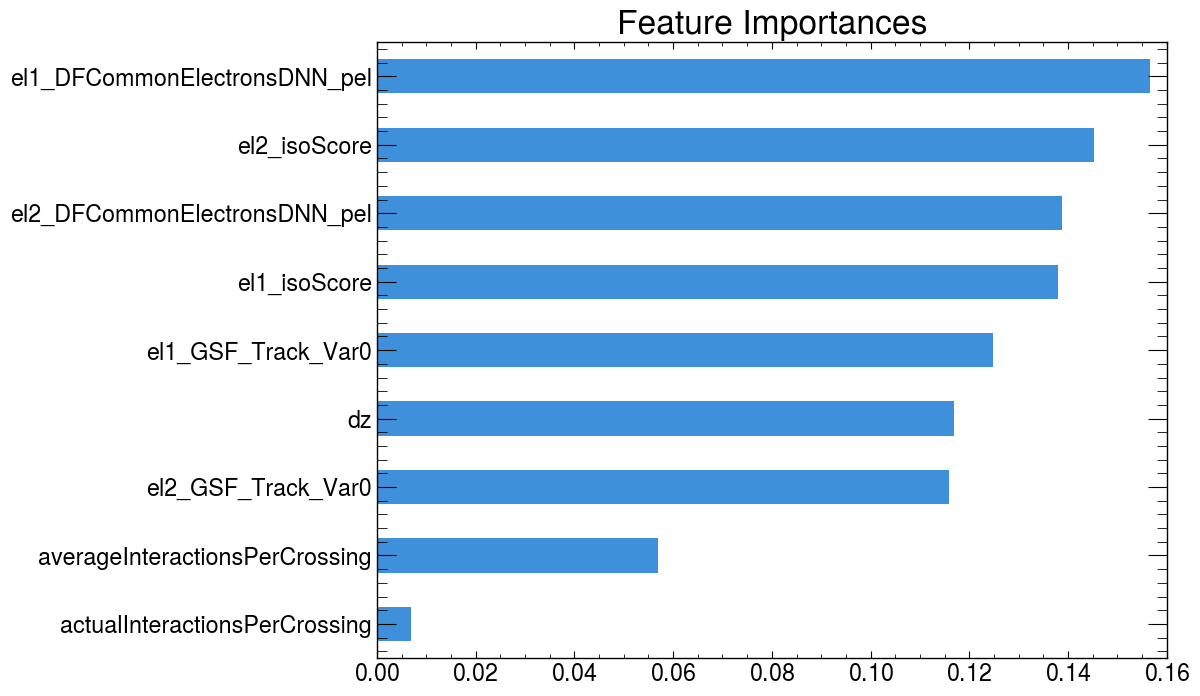

In [34]:
plt.rcdefaults()
hep.style.use([hep.style.ATLAS])

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Feature Importances')
tuner.feature_importances.sort_values().plot(ax=ax,kind='barh')
# ax.set_xticklabels(tuner.feature_importances.sort_values().index, rotation=45)
print('no')

In [35]:
print(len(X_train.columns))

9


(0.0, 1.0)

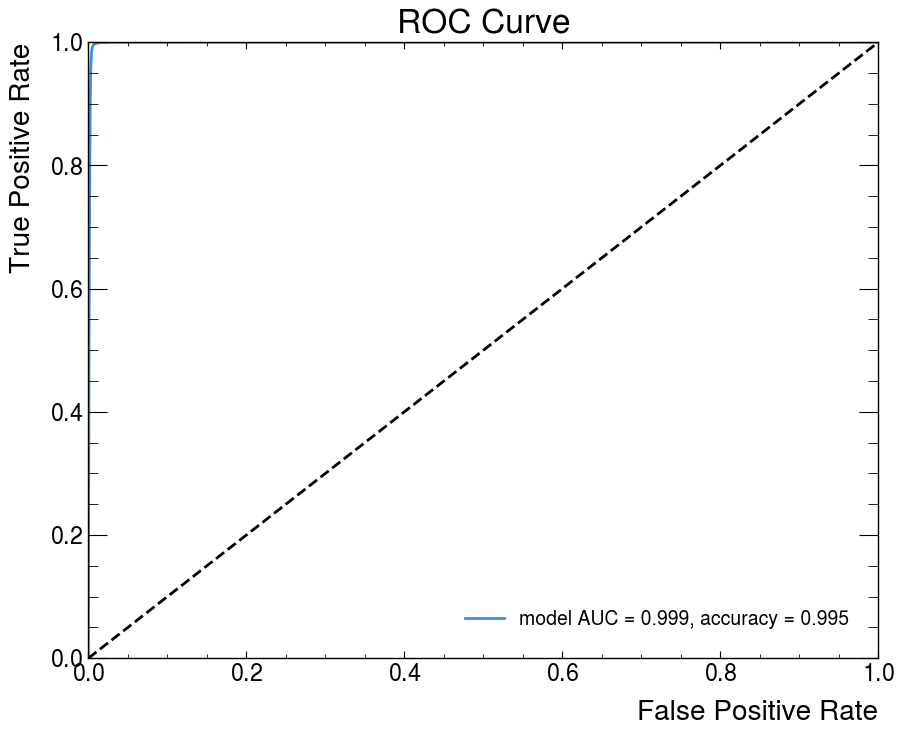

In [36]:
# roc curve
prediction = tuner.predict(test[pred_z_param_list])
score = tuner.predict_proba(test[pred_z_param_list])

fpr, tpr, _ = roc_curve(test['isZ'], score)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, label = f'model AUC = {auc(fpr, tpr):.3f}, accuracy = {np.sum(prediction==test['isZ'])/len(prediction):.3f}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.plot([0,1], [0,1], linestyle='--', color='black')
ax.legend(loc='lower right')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])


ATLAS false positives: 390
cut value: 0.9885720631890572


Text(667.340909090909, 1, 'True')

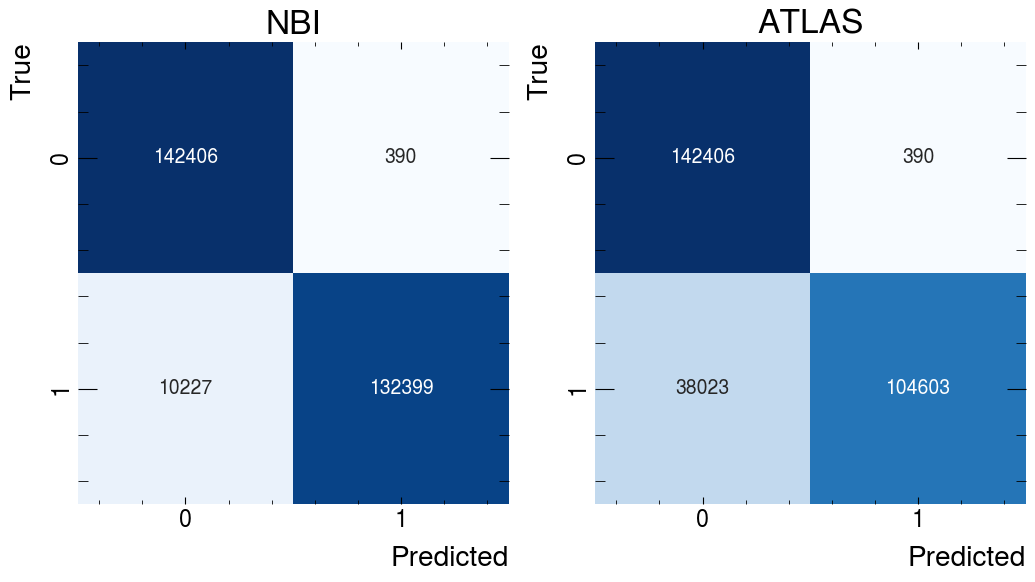

In [37]:
# find threshold to match ATLAS efficiency
fp_atlas = np.sum((test['ATLAS_label']==1) & (test['isZ']==0))
print(f'ATLAS false positives: {fp_atlas}')

cut = np.sort(score[test['isZ']==0])[-fp_atlas-1]
print(f'cut value: {cut}')

y_pred_cut = score > cut

#confusion matrixes:
cm_model = confusion_matrix(test['isZ'], y_pred_cut)
cm_ATLAS = confusion_matrix(test['isZ'], test['ATLAS_label'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm_model, annot=True, fmt='d', ax=ax[0], cmap='Blues', cbar=False)
sns.heatmap(cm_ATLAS, annot=True, fmt='d', ax=ax[1], cmap='Blues', cbar=False)
ax[0].set_title('NBI')
ax[1].set_title('ATLAS')
ax[0].set_xlabel('Predicted')
ax[1].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[1].set_ylabel('True')

Text(1, 0, '$m_{ee}$ [GeV]')

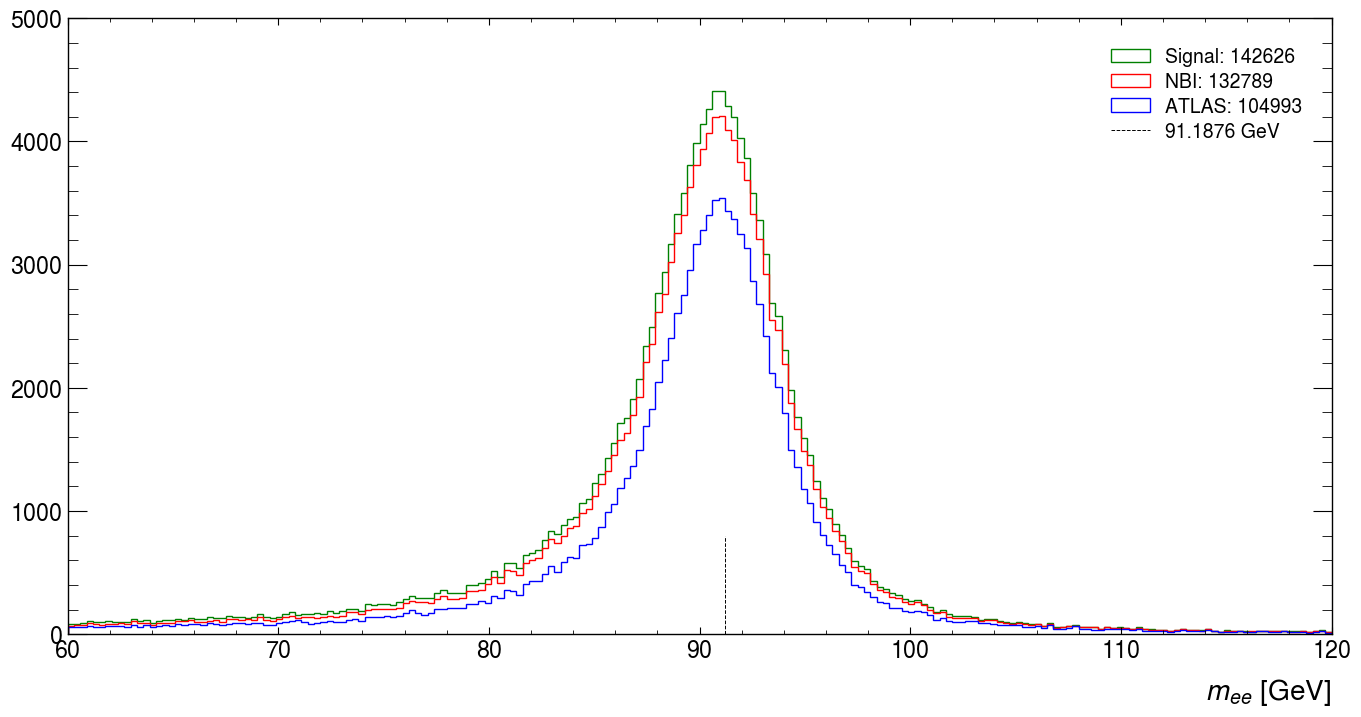

In [38]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(test['m_ee'][test['isZ'] == 1], bins=200, range=(60, 120), histtype='step', label=f'Signal: {len(test[test["isZ"] == 1])}', color='green')
ax.hist(test['m_ee'][y_pred_cut == 1], bins=200, range=(60, 120), histtype='step',color='r', label=f'NBI: {len(test[y_pred_cut == 1])}')
ax.hist(test['m_ee'][test['ATLAS_label'] == 1], bins=200, range=(60, 120), histtype='step',color='b', label=f'ATLAS: {len(test[test["ATLAS_label"] == 1])}')
ax.plot([91.1876, 91.1876], [0, 800], 'k--',linewidth=.7, label=r'91.1876 GeV')
ax.legend()
ax.set_xlabel(r'$m_{ee}$ [GeV]')


no


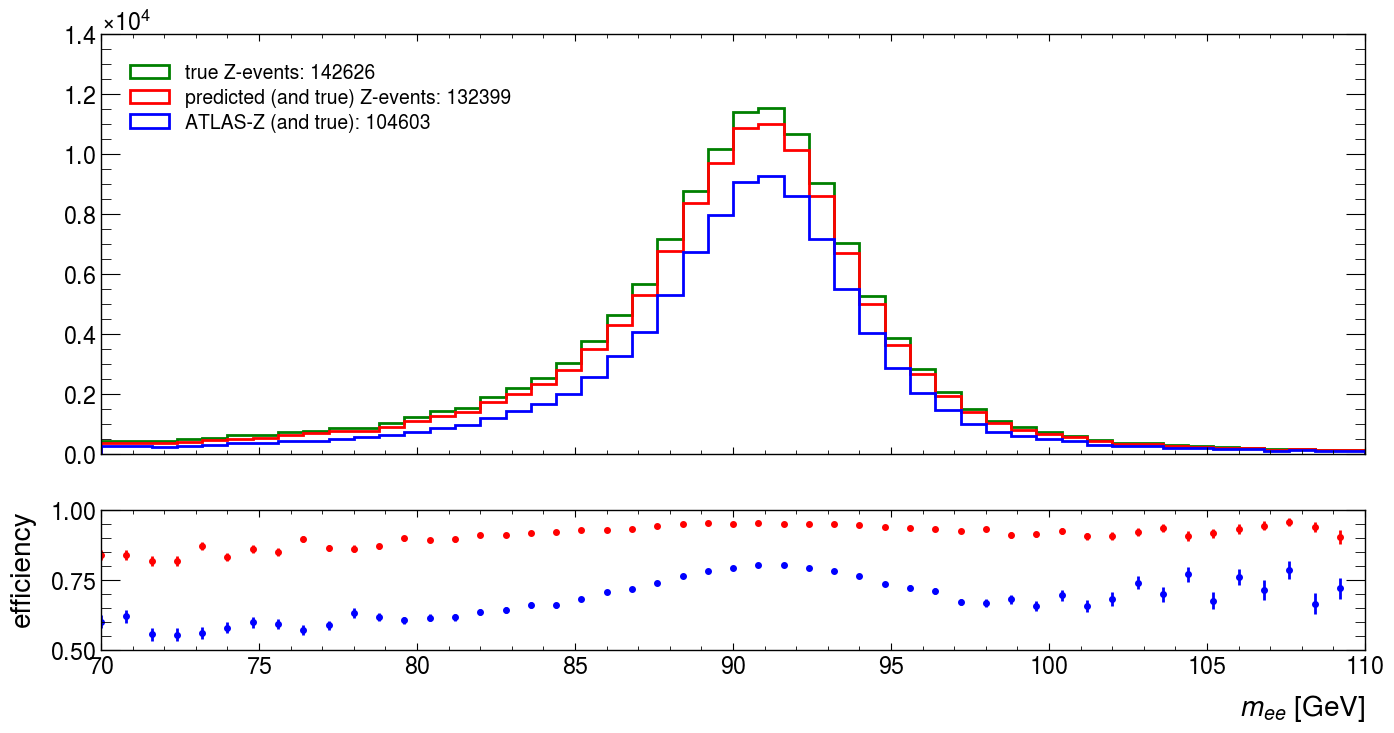

In [39]:
n_bins = 50

fig, ax = plt.subplots(2,1, figsize=(16, 8), height_ratios=[3, 1])
counts_true, bins_true, _ = ax[0].hist(test['m_ee'][test['isZ']==1], bins=n_bins, range=(70, 110),linewidth=2, histtype='step', label=f'true Z-events: {np.sum(test['isZ']==1)}', color='green')
counts_trueandmodel, bins_trueandmodel, _ = ax[0].hist(test['m_ee'][(y_pred_cut==1) & (test['isZ']==1)], bins=n_bins, range=(70, 110),linewidth=2, histtype='step',color='r', label=f'predicted (and true) Z-events: {np.sum((y_pred_cut==1) & (test["isZ"]==1))}')
counts_trueandATLAS, bins_TrueandATLAS, _ = ax[0].hist(test['m_ee'][(test['ATLAS_label']==1) & (test['isZ']==1)], bins=n_bins,linewidth=2, range=(70, 110), histtype='step',color='b', label=f'ATLAS-Z (and true): {np.sum((test["ATLAS_label"]==1) & (test["isZ"]==1))}')
ax[0].legend(loc='upper left')
ax[0].set_xticklabels([])
eff_model = counts_trueandmodel/counts_true
eff_ATLAS = counts_trueandATLAS/counts_true

uncertainty_model = np.sqrt(eff_model*(1-eff_model)/counts_true)
uncertainty_ATLAS = np.sqrt(eff_ATLAS*(1-eff_ATLAS)/counts_true)

ax[1].errorbar(bins_true[:-1], eff_model, yerr=uncertainty_model, fmt='.', label='model', color='r')
ax[1].errorbar(bins_true[:-1], eff_ATLAS, yerr=uncertainty_ATLAS, fmt='.', label='ATLAS', color='b')
ax[1].set_xlabel('$m_{ee}$ [GeV]')
ax[1].set_ylabel('efficiency')
ax[1].set_ylim(0.5,1)

# ax[0].set_title('Zee model on Zee data')
# ax[1].legend()

print('no')

no


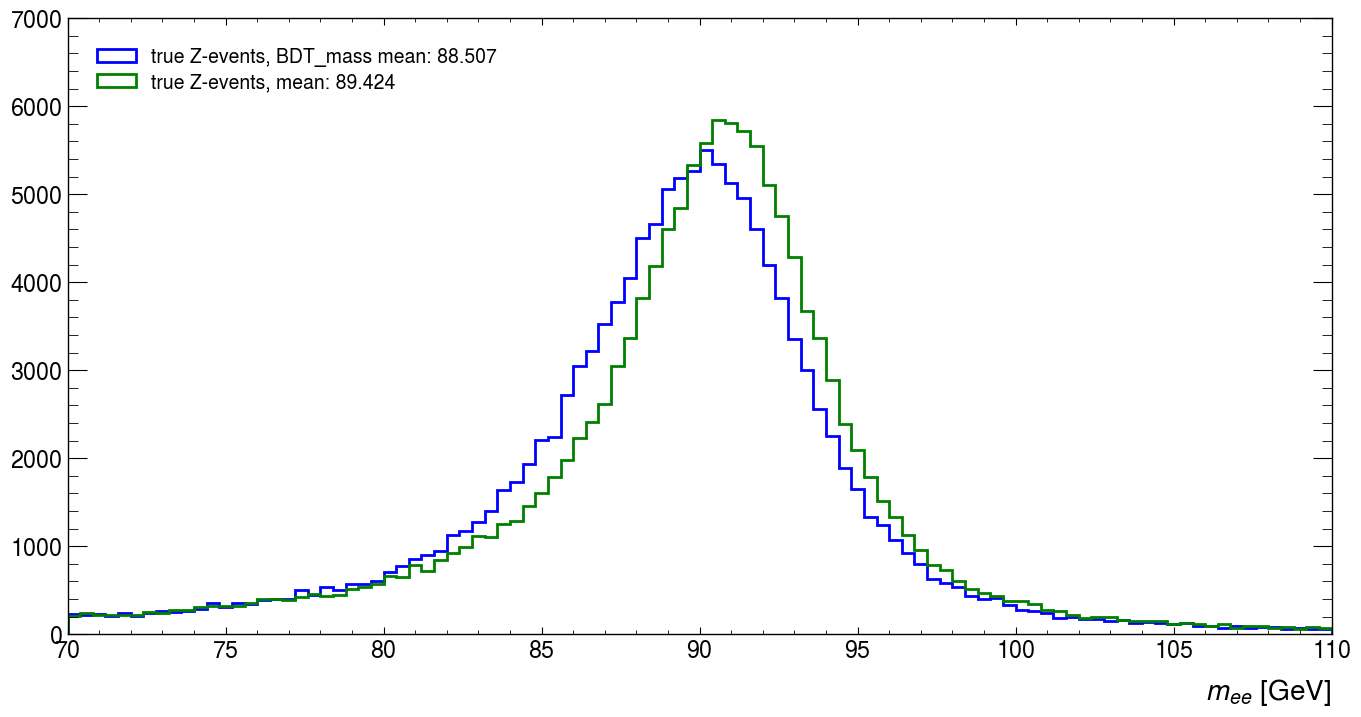

In [40]:
n_bins = 100

fig, ax = plt.subplots( figsize=(16, 8))

ax.hist(test['m_ee_bdt'][test['isZ']==1], bins=n_bins, range=(70, 110), linewidth=2, histtype='step', label=f'true Z-events, BDT_mass mean: {np.mean(test['m_ee_bdt'][test['isZ']==1]):.3f}', color='b')
ax.hist(test['m_ee'][test['isZ']==1], bins=n_bins, range=(70, 110),linewidth=2, histtype='step', label=f'true Z-events, mean: {np.mean(test['m_ee'][test['isZ']==1]):.3f}', color='green')
ax.legend(loc='upper left')
ax.set_xlabel(r'$m_{ee}$ [GeV]')
# ax[0].set_xticklabels([])
eff_model = counts_trueandmodel/counts_true
eff_ATLAS = counts_trueandATLAS/counts_true


# ax[0].set_title('Zee model on Zee data')
# ax[1].legend()

print('no')

Text(1, 0, '$m_{ee}$ [GeV]')

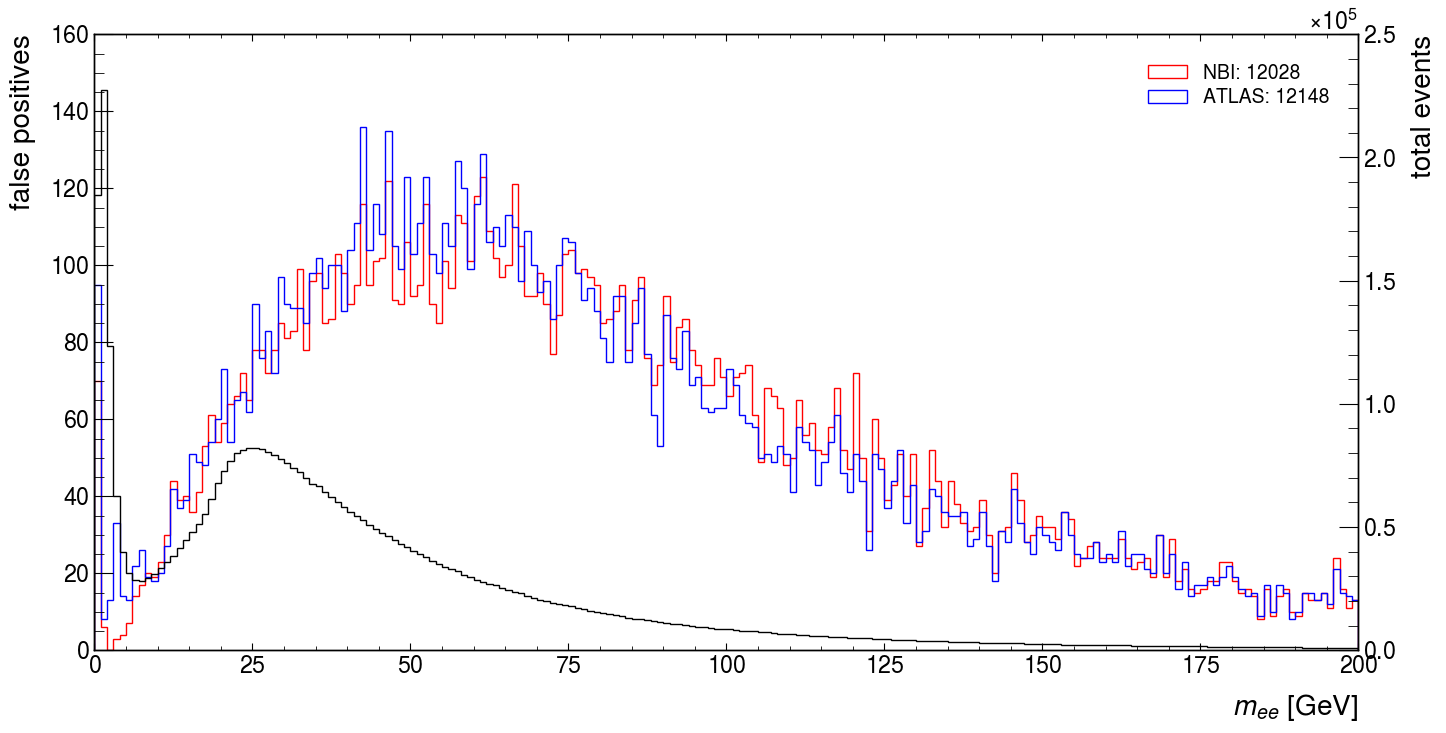

In [41]:
ttbar_score = tuner.predict_proba(data_ttbar[pred_z_param_list])
ttbar_prediction = ttbar_score > cut
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(data_ttbar['m_ee'][ttbar_prediction == 1], bins=200, range=(0, 200), histtype='step',color='r', label=f'NBI: {len(data_ttbar[ttbar_prediction == 1])}')
ax.hist(data_ttbar['m_ee'][data_ttbar['ATLAS_label'] == 1], bins=200, range=(0, 200), histtype='step',color='b', label=f'ATLAS: {len(data_ttbar[data_ttbar["ATLAS_label"] == 1])}')
ax2 = ax.twinx()
ax2.hist(data_ttbar['m_ee'],color='black', bins=200, range=(0, 200), histtype='step', label=f'TTbar: {len(data_ttbar)}')
ax.legend()
ax.set_ylabel('false positives')
ax2.set_ylabel('total events')
ax.set_xlabel(r'$m_{ee}$ [GeV]')

- make new pair files with trigger variable
- make training (as above) for different sig/bck ratios, save ATLAS/MODEL ratio for sig/bck and pure bck
- 

no


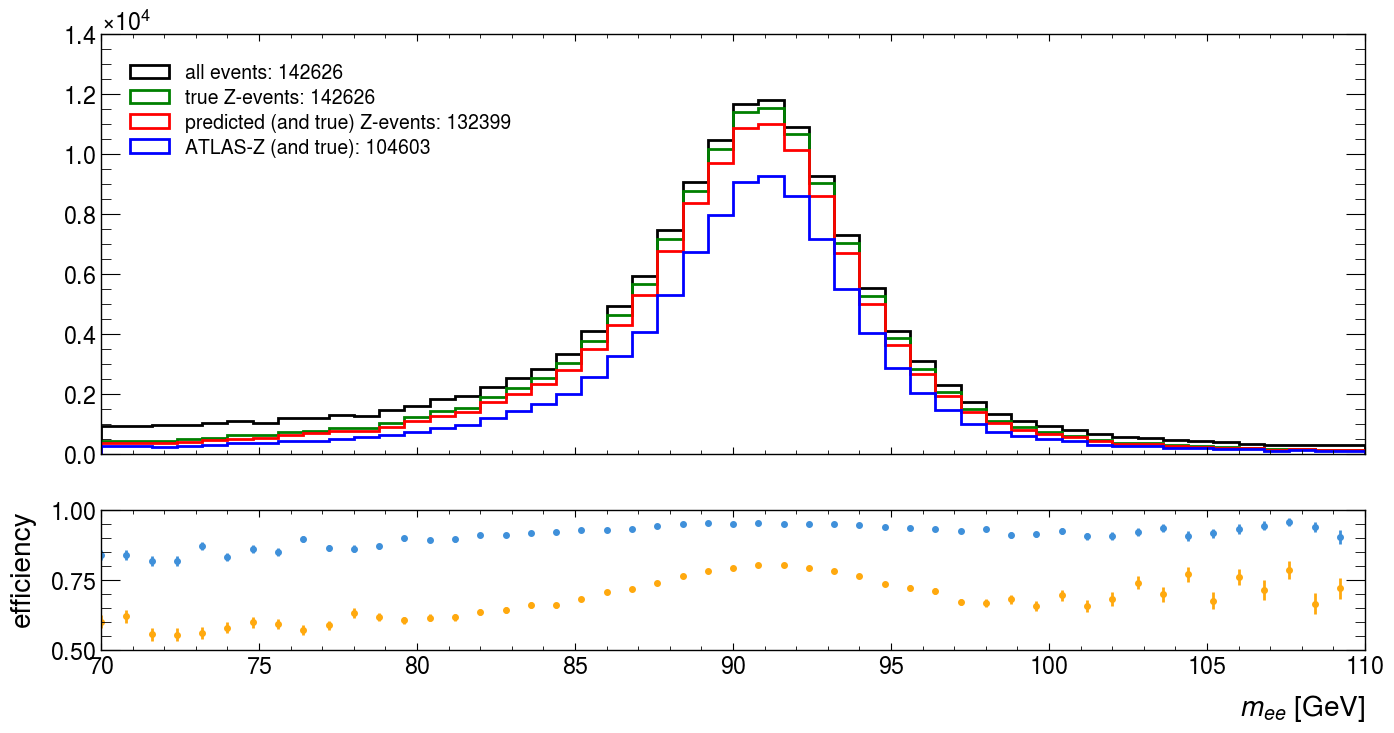

In [42]:
n_bins = 50

fig, ax = plt.subplots(2,1, figsize=(16, 8), height_ratios=[3, 1])
ax[0].hist(test['m_ee'], bins=n_bins, range=(70, 110),linewidth=2, histtype='step', label=f'all events: {np.sum(test["isZ"]==1)}', color='k')
counts_true, bins_true, _ = ax[0].hist(test['m_ee'][test['isZ']==1], bins=n_bins, range=(70, 110),linewidth=2, histtype='step', label=f'true Z-events: {np.sum(test['isZ']==1)}', color='green')
counts_trueandmodel, bins_trueandmodel, _ = ax[0].hist(test['m_ee'][(y_pred_cut==1) & (test['isZ']==1)], bins=n_bins, range=(70, 110),linewidth=2, histtype='step', label=f'predicted (and true) Z-events: {np.sum((y_pred_cut==1) & (test["isZ"]==1))}',color='red')
counts_trueandATLAS, bins_TrueandATLAS, _ = ax[0].hist(test['m_ee'][(test['ATLAS_label']==1) & (test['isZ']==1)], bins=n_bins,linewidth=2, range=(70, 110), histtype='step', label=f'ATLAS-Z (and true): {np.sum((test["ATLAS_label"]==1) & (test["isZ"]==1))}',color='blue')
ax[0].legend(loc='upper left')
ax[0].set_xticklabels([])
eff_model = counts_trueandmodel/counts_true
eff_ATLAS = counts_trueandATLAS/counts_true

uncertainty_model = np.sqrt(eff_model*(1-eff_model)/counts_true)
uncertainty_ATLAS = np.sqrt(eff_ATLAS*(1-eff_ATLAS)/counts_true)

ax[1].errorbar(bins_true[:-1], eff_model, yerr=uncertainty_model, fmt='.', label='model')
ax[1].errorbar(bins_true[:-1], eff_ATLAS, yerr=uncertainty_ATLAS, fmt='.', label='ATLAS')
ax[1].set_xlabel('$m_{ee}$ [GeV]')
ax[1].set_ylabel('efficiency')
ax[1].set_ylim(0.5,1)

# ax[0].set_title('Zee model on Zee data')
# ax[1].legend()

print('no')

In [43]:
print(test['trigger'].value_counts())
print(len(test))

trigger
True    285422
Name: count, dtype: int64
285422


In [ ]:
print(data_ttbar['trigger'].value_counts())
print(len(data_ttbar))

trigger
True    4611208
Name: count, dtype: int64
4611208


In [45]:
import shap
import time

In [ ]:
# time_0 = time.time()
# model = tuner._fitted_model
# explainer = shap.Explainer(model)
# shapdata = test[pred_z_param_list].head(3).copy()
# shap_values = explainer(shapdata)
# shap.plots.waterfall(shap_values[0])
# time_1 = time.time()
# print(f'time: {time_1-time_0}')

Locator attempting to generate 5999999504 ticks ([-11.999999999277943, ..., -3.935731740511983e-10]), which exceeds Locator.MAXTICKS (1000).
